In [1]:
import os
import re

import pandas as pd
import numpy as np

from tensorflow.keras.layers import Conv2D, Dense, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [3]:
# accessing my drive 

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# data folders

train_path = '/content/drive/MyDrive/Data/final_project/dataset/train'
valid_path = '/content/drive/MyDrive/Data/final_project/dataset/valid'
test_path = '/content/drive/MyDrive/Data/final_project/dataset/test'

In [5]:
# creating a dataframe for the train folder with the images and their class

train_images_path = '/content/drive/MyDrive/Data/final_project/dataset/train/images'
image_files_train = [file for file in os.listdir(train_images_path) if file.endswith('.jpg')]
class_labels_train = [re.search(r'\d+', file.split('_')[0]).group() for file in image_files_train]
train_df = pd.DataFrame({'filename': image_files_train, 'class': class_labels_train})

# creating a dataframe for the valid folder with the images and their class

valid_images_path = '/content/drive/MyDrive/Data/final_project/dataset/valid/images'
image_files_valid = [file for file in os.listdir(valid_images_path) if file.endswith('.jpg')]
class_labels_valid = [re.search(r'\d+', file.split('_')[0]).group() for file in image_files_valid]
validation_df = pd.DataFrame({'filename': image_files_valid, 'class': class_labels_valid})

# creating a dataframe for the test folder with the images and their class

test_images_path = '/content/drive/MyDrive/Data/final_project/dataset/test/images'
image_files_test = [file for file in os.listdir(test_images_path) if file.endswith('.jpg')]
class_labels_test = [re.search(r'\d+', file.split('_')[0]).group() for file in image_files_test]
test_df = pd.DataFrame({'filename': image_files_test, 'class': class_labels_test})

In [6]:
# confirming it has the right structure

train_df['class'].value_counts()

1    433
5    315
0    306
4    299
2    283
3    168
Name: class, dtype: int64

In [8]:
# real-time data augmentation and preparing the data for training

batch_size = 32
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory=train_images_path,
    x_col='filename',
    y_col='class',
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=True
)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validation_df,
    directory=valid_images_path,
    x_col='filename',
    y_col='class',
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode='sparse'
)

test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    directory=test_images_path,
    target_size=(299, 299),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)

Found 1804 validated image filenames belonging to 6 classes.
Found 173 validated image filenames belonging to 6 classes.
Found 83 validated image filenames.


In [9]:
# this time, different from the others, I am trying to create a model from scratch, with the convolutional and dense layers,
# dropout's, then the output layer and compiling all. Also, I used more epochs this time. This whole model takes a long time to run
# and the result was not the best. I believe with more fine-tuning and try-error, one can increase the accuracy and the model performance, 
# but it is a time demanding task, with need for a high performance GPU. 

model = Sequential()

# convolutional layers

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(299, 299, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# flatten the output and add Dense layers

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))  
model.add(Dense(32, activation='relu'))

model.add(Dense(6, activation='softmax'))  

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 297, 297, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 148, 148, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 146, 146, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 73, 73, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 35, 35, 128)      

In [10]:
# training the model

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model-w/o-morelayers.h5', save_best_only=True)
history = model.fit(train_generator, epochs=50, validation_data=validation_generator, verbose=2, callbacks=[early_stopping, checkpoint] )

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


57/57 - 526s - loss: 1.8414 - accuracy: 0.2084 - val_loss: 1.7843 - val_accuracy: 0.2370 - 526s/epoch - 9s/step
Epoch 2/50
57/57 - 414s - loss: 1.7745 - accuracy: 0.2289 - val_loss: 1.7730 - val_accuracy: 0.2370 - 414s/epoch - 7s/step
Epoch 3/50
57/57 - 434s - loss: 1.7603 - accuracy: 0.2334 - val_loss: 1.7540 - val_accuracy: 0.2370 - 434s/epoch - 8s/step
Epoch 4/50
57/57 - 421s - loss: 1.7451 - accuracy: 0.2350 - val_loss: 1.7290 - val_accuracy: 0.2197 - 421s/epoch - 7s/step
Epoch 5/50
57/57 - 409s - loss: 1.7269 - accuracy: 0.2373 - val_loss: 1.6675 - val_accuracy: 0.2197 - 409s/epoch - 7s/step
Epoch 6/50
57/57 - 418s - loss: 1.6931 - accuracy: 0.2417 - val_loss: 1.6594 - val_accuracy: 0.2486 - 418s/epoch - 7s/step
Epoch 7/50
57/57 - 428s - loss: 1.6670 - accuracy: 0.2722 - val_loss: 1.5718 - val_accuracy: 0.2890 - 428s/epoch - 8s/step
Epoch 8/50
57/57 - 418s - loss: 1.6731 - accuracy: 0.2844 - val_loss: 1.6256 - val_accuracy: 0.2717 - 418s/epoch - 7s/step
Epoch 9/50
57/57 - 418s - l

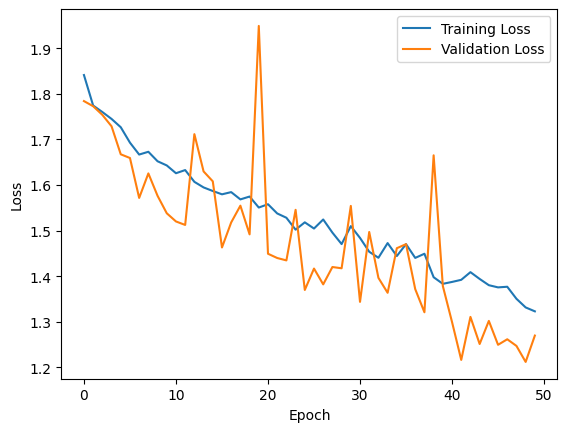

In [11]:
# plotting the val and training loss

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
# evaluating model on validation set

val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}')


6/6 [==============================] - 10s 2s/step - loss: 1.2698 - accuracy: 0.5260
Validation Loss: 1.2697535753250122, Validation Accuracy: 0.52601158618927


In [13]:
# making predictions on the test set

test_predictions = model.predict(test_generator)

# printing the predicted class for each test image

test_predicted_classes = np.argmax(test_predictions, axis=1)
test_df['predicted_class'] = test_predicted_classes
print(test_df)



3/3 [==============================] - 38s 18s/step
          filename class  predicted_class
0   2_53395435.jpg     2                0
1   4_06589b88.jpg     4                4
2   1_2da89017.jpg     1                0
3   5_3d203d11.jpg     5                5
4   1_aed57c6b.jpg     1                1
..             ...   ...              ...
78  4_76253060.jpg     4                5
79  4_617cc4fc.jpg     4                4
80  4_3b7bfb6a.jpg     4                4
81  1_96547eff.jpg     1                1
82  4_54f49b99.jpg     4                5

[83 rows x 3 columns]


In [14]:
# calling the true labels for the test set

true_labels = [int(label) for label in test_df['class']]

# accuracy

accuracy = accuracy_score(true_labels, test_predicted_classes)
print(f'Accuracy: {accuracy:.2%}')

# classification report

print('Classification Report:')
print(classification_report(true_labels, test_predicted_classes))

# confusion matrix

print('Confusion Matrix:')
print(confusion_matrix(true_labels, test_predicted_classes))


Accuracy: 57.83%
Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.46      0.39        13
           1       0.68      0.77      0.72        22
           2       0.50      0.15      0.24        13
           3       0.00      0.00      0.00         6
           4       0.69      0.79      0.73        14
           5       0.60      0.80      0.69        15

    accuracy                           0.58        83
   macro avg       0.47      0.50      0.46        83
weighted avg       0.54      0.58      0.54        83

Confusion Matrix:
[[ 6  3  0  0  2  2]
 [ 2 17  1  0  1  1]
 [ 6  2  2  0  2  1]
 [ 2  2  1  0  0  1]
 [ 0  0  0  0 11  3]
 [ 2  1  0  0  0 12]]


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
